In [203]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
import numpy as np
import scipy
%matplotlib inline

In [2]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv", header= None)
df_train.shape

(60000, 785)

In [3]:
df_test = pd.read_csv("/data/MNIST/mnist_test.csv", header= None)
df_test.shape

(10000, 785)

In [4]:
28*28 

784

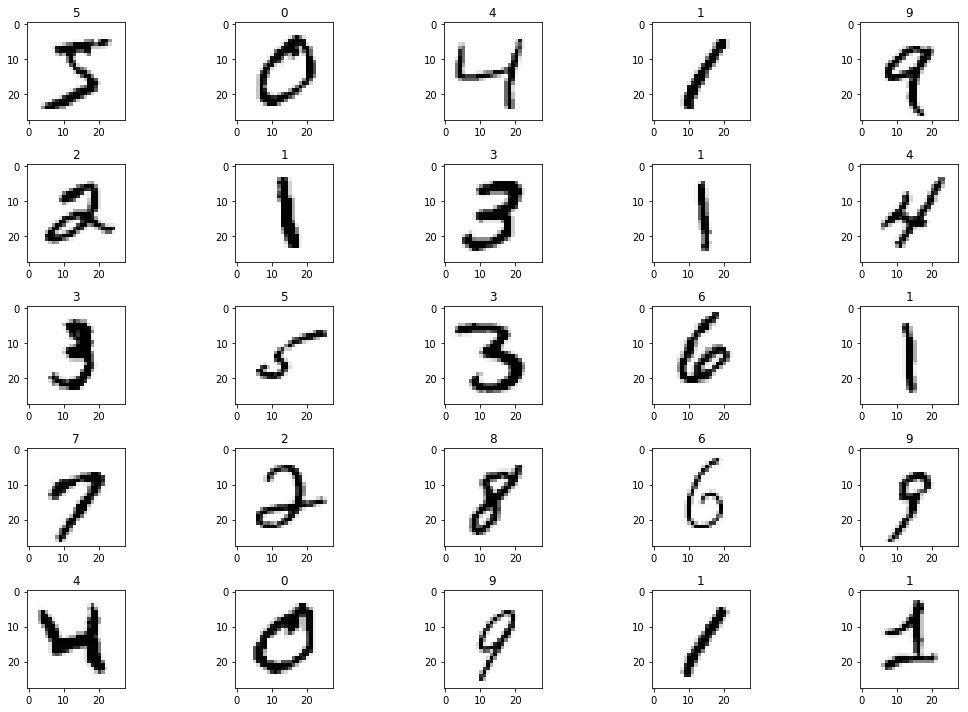

In [5]:
fig, _ = plt.subplots(5, 5, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    ax.imshow(df_train.iloc[i, 1:].values.reshape(28, -1), cmap="Greys")
    ax.set_title(df_train.iloc[i, 0])

plt.tight_layout()

In [6]:
X_train = df_train.iloc[:, 1:].values
X_test = df_test.iloc[:, 1:].values
y_train = df_train.iloc[:, 0]
y_test = df_test.iloc[:, 0]


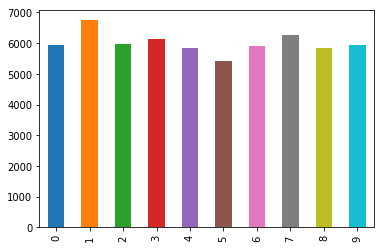

In [7]:
pd.Series(y_train).value_counts().sort_index().plot.bar()

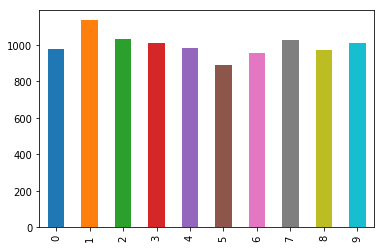

In [8]:
pd.Series(y_test).value_counts().sort_index().plot.bar()

In [50]:
np.sum(X_train.flatten() > 0) / len(X_train.flatten())

0.19120229591836735

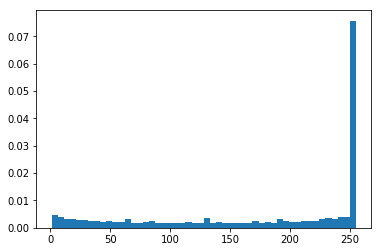

In [57]:
s = X_train.flatten()
s = s[s > 0]
plt.hist(s, bins = 50, normed = True);

In [10]:
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train.astype(np.float64))
X_test_std = scaler.transform(X_test.astype(np.float64))

In [40]:
%%time
est = linear_model.LogisticRegression(C = 1.0, random_state = 1, multi_class="multinomial",
                                      solver="lbfgs", max_iter=10000)
est.fit(X_train_std, y_train)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9212 iterations: [892]
CPU times: user 9min 7s, sys: 19.3 s, total: 9min 27s
Wall time: 2min 47s


In [42]:
est.coef_.shape

(10, 784)

In [43]:
%%time
np.random.seed(1)
inits = np.random.randn(10, 784) 
inits = inits / np.std(inits, axis=1).reshape(10, -1)

est = linear_model.SGDClassifier(n_jobs=4, tol=1e-5, eta0 = 0.15, random_state=1,  
                                 learning_rate = "invscaling", 
                                 alpha = 0.01, max_iter= 100)
est.fit(X_train_std, y_train, inits)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9216 iterations: 59
CPU times: user 33.9 s, sys: 341 ms, total: 34.2 s
Wall time: 12.3 s


In [44]:
est.coef_.shape

(10, 784)

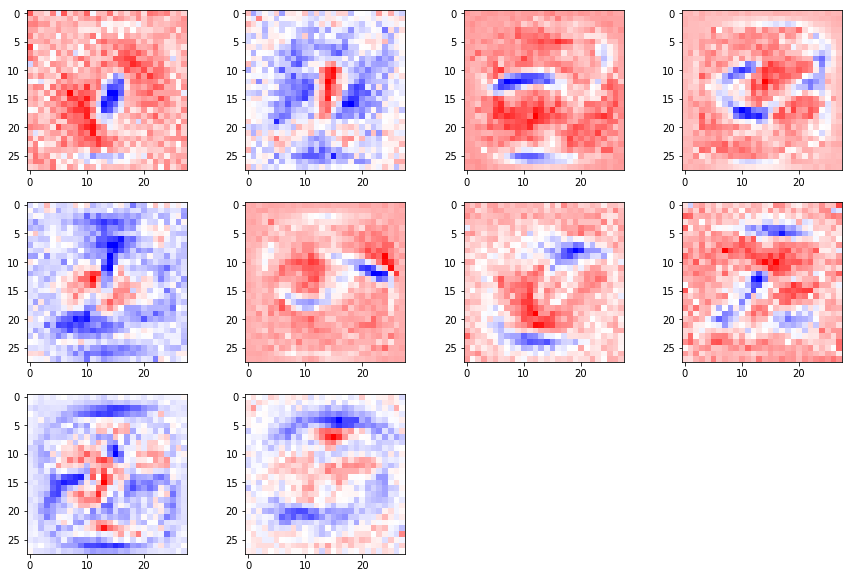

In [45]:
fig, _ = plt.subplots(3, 4, figsize = (15, 10))
for i, ax in enumerate(fig.axes):
    if i < est.coef_.shape[0]:
        ax.imshow(est.coef_[i, :].reshape(28, 28), cmap = "bwr", interpolation="nearest")
    else:
        ax.remove()

# Impact of dimensionality reduction

In [205]:
%%time
est = linear_model.SGDClassifier(n_jobs=4, tol=1e-5, eta0 = 0.15, random_state=1,  
                                 learning_rate = "invscaling", 
                                 alpha = 0.01, max_iter= 100)
est.fit(X_train_std, y_train, inits)
print("accuracy", est.score(X_test_std, y_test), "iterations:", est.n_iter_)

accuracy 0.9174 iterations: 14
CPU times: user 10.2 s, sys: 215 ms, total: 10.4 s
Wall time: 3.7 s


In [206]:
pca = decomposition.PCA(random_state=1)
pca.fit(X_train_std)                  

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'Explained variance ratio')

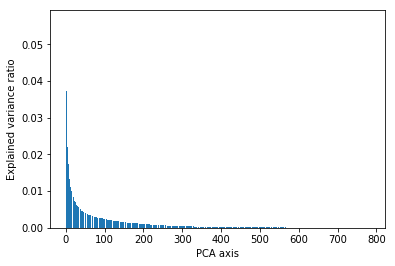

In [209]:
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("PCA axis")
plt.ylabel("Explained variance ratio")

Text(0,0.5,'Cumulative explained variance')

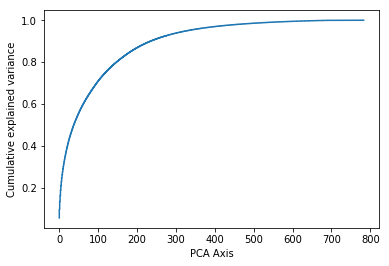

In [211]:
plt.step(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("PCA Axis")
plt.ylabel("Cumulative explained variance")

In [213]:
v = pd.DataFrame({"pca": np.cumsum(pca.explained_variance_ratio_)}).query("pca > 0.99")
v.head()

,pca
542,0.990088
543,0.990183
544,0.990276
545,0.990369
546,0.990462


In [221]:
n_pca = v.index[0]
n_pca, (1 - n_pca/X_train_std.shape[1])

(542, 0.30867346938775508)

In [219]:
%%time
pca = decomposition.PCA(random_state=1, n_components=n_pca)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print("X_train shape", X_train_pca.shape)

X_train shape (60000, 542)
CPU times: user 54.1 s, sys: 2.82 s, total: 56.9 s
Wall time: 25 s


In [220]:
%%time
est = linear_model.SGDClassifier(n_jobs=4, tol=1e-5, eta0 = 0.15, random_state=1,  
                                 learning_rate = "invscaling", 
                                 alpha = 0.01, max_iter= 100)
est.fit(X_train_pca, y_train)
print("accuracy", est.score(X_test_pca, y_test), "iterations:", est.n_iter_)

accuracy 0.9184 iterations: 15
CPU times: user 8.02 s, sys: 155 ms, total: 8.18 s
Wall time: 2.72 s


By reducing the dimension by 30% we reduce the training time without a significant drop in accuracy.

# Batch gradient descent using Tensorflow

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.52437
10 0.504713
20 0.407154
30 0.353561
40 0.317242
50 0.292892
60 0.277241
70 0.266509
80 0.258999
90 0.253509
Test accuracy:  0.9227
CPU times: user 1min 20s, sys: 40.6 s, total: 2min 1s
Wall time: 1min


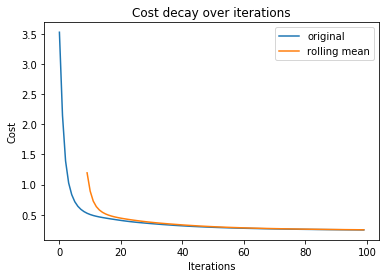

In [115]:
%%time

tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], len(np.unique(y_train)) 
max_iter = 100
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)


W = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, 
                                    seed = 1, dtype=tf.float32), name = "W")
b = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W)

Z = tf.matmul(X, W) + b
print("Z: ", Z)

y_pred = tf.cast(tf.argmax(Z, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z))

optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    for i in range(max_iter):
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_train_std, y: y_train})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)

# Mini batch gradient descent

In [148]:
import requests
url = "https://raw.githubusercontent.com/abulbasar/machine-learning/master/Utils.py"
exec(requests.get(url).text)

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.63887
100 0.484621
200 1.73197
300 0.762925
400 0.244644
500 0.529764
600 0.286891
700 0.160542
800 0.439102
900 0.770548
Test accuracy:  0.9174
CPU times: user 3.26 s, sys: 412 ms, total: 3.68 s
Wall time: 3.26 s


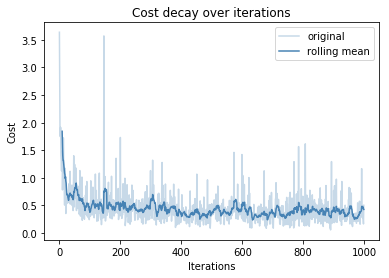

In [151]:
%%time 

tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 # number of features of df is 4, and output is single value 
max_iter = 1000
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W")
b = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

Z = tf.matmul(X, W) + b
print("Z: ", Z)

y_pred = tf.cast(tf.argmax(Z, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=64, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)
    
    

# No hidden layer 

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.63887
100 0.484621
200 1.73197
300 0.762925
400 0.244644
500 0.529764
600 0.286891
700 0.160542
800 0.439102
900 0.770548
Test accuracy:  0.9174


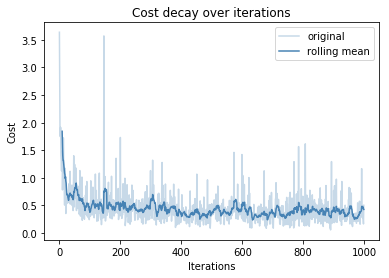

In [152]:
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 # number of features of df is 4, and output is single value 
max_iter = 1000
alpha = 100


X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W1 = tf.Variable(tf.truncated_normal([n_x, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W")
b1 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b")

Z1 = tf.matmul(X, W1) + b1
print("Z: ", Z1)

y_pred = tf.cast(tf.argmax(Z1, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=64, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_ = sess.run(accuracy, feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)
    
    

# Regularize model

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 200), dtype=float32)
A1: Tensor("Tanh:0", shape=(?, 200), dtype=float32)
Z:  Tensor("add:0", shape=(?, 200), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.60645
100 1.60136
200 1.34029
300 1.39705
400 1.14989
500 1.29865
600 1.16924
700 1.05121
800 1.23276
900 1.32962
Test accuracy:  0.9204


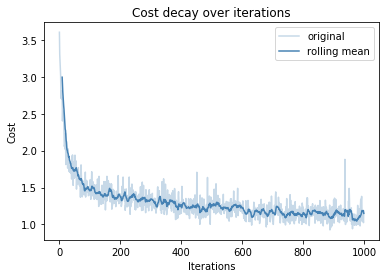

In [154]:
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], 10 
max_iter = 1000
alpha = 100
n_h = 200

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W1 = tf.Variable(tf.truncated_normal([n_x, n_h], stddev=0.1, seed = 1, dtype=tf.float32), name = "W1")
b1 = tf.Variable(tf.zeros(shape=[n_h]), dtype=tf.float32, name="b1")

Z1 = tf.matmul(X, W1) + b1
print("Z: ", Z1)

A1 = tf.nn.tanh(Z1)
print("A1:", A1)

W2 = tf.Variable(tf.truncated_normal([n_h, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W2")
b2 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b2")

Z2 = tf.matmul(A1, W2) + b2
print("Z: ", Z1)


y_pred = tf.cast(tf.argmax(Z2, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

reg_penalty = (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)) / tf.cast(tf.shape(X)[0], tf.float32)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z2)) \
                + 0.1 * reg_penalty

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(cost)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=64, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_, y_test_pred = sess.run([accuracy, y_pred], feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)
    
    

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 400), dtype=float32)
A1: Tensor("Tanh:0", shape=(?, 400), dtype=float32)
Z2:  Tensor("add_1:0", shape=(?, 10), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.2614
200 0.524644
400 0.378422
600 0.348137
800 0.381931
1000 0.392987
1200 0.315553
1400 0.461374
1600 0.396431
1800 0.28808
Test accuracy:  0.9227


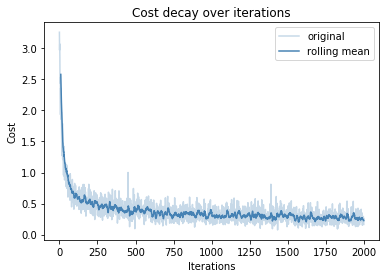

In [267]:
tf.reset_default_graph()
n_x, n_y = X_train_std.shape[1], len(np.unique(y_train)) 
max_iter = 2000
batch_size = 64
alpha = 0.01
n_h = 400
learning_rate = 0.02

X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

print("X:", X)
print("y:", y)

W1 = tf.Variable(tf.truncated_normal([n_x, n_h], stddev=0.1, seed = 1, dtype=tf.float32), name = "W1")
b1 = tf.Variable(tf.zeros(shape=[n_h]), dtype=tf.float32, name="b1")

Z1 = tf.matmul(X, W1) + b1
print("Z: ", Z1)

A1 = tf.nn.tanh(Z1)
print("A1:", A1)

W2 = tf.Variable(tf.truncated_normal([n_h, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W2")
b2 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b2")

Z2 = tf.matmul(A1, W2) + b2
print("Z2: ", Z2)


y_pred = tf.cast(tf.argmax(Z2, axis=1), tf.int32)
print("y_pred: ", y_pred)

matched = tf.equal(y_pred, y)
print("matched:", matched)

accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
print("accuracy: ", accuracy)

tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W1)
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W2)

regularizer = tf.contrib.layers.l2_regularizer(scale=alpha)
reg_penalty = tf.contrib.layers.apply_regularization(regularizer, 
                        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z2))
cost_reg = cost + reg_penalty
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_reg)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    scores = {}
    
    batchable = Batchable(X_train_std, y_train, batch_size=batch_size, seed=1)
    
    for i in range(max_iter):
        X_batch, y_batch = batchable.next()
        cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
        scores[i] = cost_
        if i % (max_iter // 10) == 0:
            print(i, cost_)
   
    accuracy_, y_test_pred = sess.run([accuracy, y_pred], feed_dict={X: X_test_std, y: y_test})

    print("Test accuracy: ", accuracy_)
    plot_scores(scores)
    
    

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 400), dtype=float32)
A1: Tensor("Tanh:0", shape=(?, 400), dtype=float32)
Z:  Tensor("add:0", shape=(?, 400), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.20951
200 0.486597
400 0.384309
600 0.351643
800 0.390751
1000 0.330908
1200 0.289101
1400 0.263173
1600 0.266386
1800 0.186232
Test accuracy:  [0.92250001]


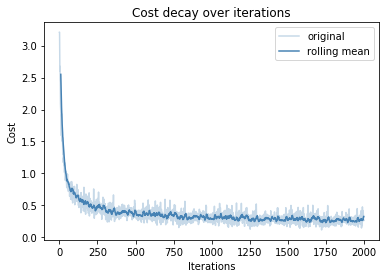

In [268]:

class FCNN():
    
    def __init__(self, 
                 max_iter = 1000, 
                 batch_size = 128, 
                 alpha = 0.01, 
                 n_h = 100, 
                 learning_rate = 0.02):
        self.max_iter = max_iter
        self.batch_size = 128
        self.alpha = alpha
        self.n_h = n_h
        self.learning_rate = learning_rate
    
    def __enter__(self):
        return self
        
    def fit(self, X_data, y_data):
        tf.reset_default_graph()
        sess = tf.Session()
        n_x, n_y = X_data.shape[1], len(np.unique(y_data))

        X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
        y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

        y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

        print("X:", X)
        print("y:", y)

        W1 = tf.Variable(tf.truncated_normal([n_x, n_h], stddev=0.1, seed = 1, dtype=tf.float32), name = "W1")
        b1 = tf.Variable(tf.zeros(shape=[n_h]), dtype=tf.float32, name="b1")

        Z1 = tf.matmul(X, W1) + b1
        print("Z: ", Z1)

        A1 = tf.nn.tanh(Z1)
        print("A1:", A1)

        W2 = tf.Variable(tf.truncated_normal([n_h, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W2")
        b2 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b2")

        Z2 = tf.matmul(A1, W2) + b2
        print("Z: ", Z1)


        y_pred = tf.cast(tf.argmax(Z2, axis=1), tf.int32)
        print("y_pred: ", y_pred)

        matched = tf.equal(y_pred, y)
        print("matched:", matched)

        accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
        print("accuracy: ", accuracy)

        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W1)
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W2)

        regularizer = tf.contrib.layers.l2_regularizer(scale=self.alpha)
        reg_penalty = tf.contrib.layers.apply_regularization(regularizer, 
                                tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z2))
        cost_reg = cost + reg_penalty
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(cost_reg)
        
        sess.run(tf.global_variables_initializer())
        scores = {}
        batchable = Batchable(X_data, y_data, batch_size=self.batch_size, seed=1)

        for i in range(max_iter):
            X_batch, y_batch = batchable.next()
            cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
            scores[i] = cost_
            if i % (max_iter // 10) == 0:
                print(i, cost_)
        plot_scores(scores)
                
        self.X = X
        self.y = y
        self.y_pred = y_pred
        self.accuracy = accuracy
        self.sess = sess
        return
    
    def predict(self, X_data):
        sess = self.sess
        X = self.X
        y = self.y
        y_pred_ = sess.run([self.y_pred], feed_dict={X: X_data})
        return y_pred_
    
    def score(self, X_data, y_data):
        sess = self.sess
        X = self.X
        y = self.y
        accuracy_ = sess.run([self.accuracy], feed_dict={X: X_data, y: y_data})
        return accuracy_
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.sess.close()

    
with FCNN() as nn:
    nn.fit(X_train_std, y_train)
    nn.predict(X_test_std)
    print("Test accuracy: ", nn.score(X_test_std, y_test))

# Convolutional neural network using Tensorflow 

X: Tensor("X:0", shape=(?, 784), dtype=float32)
y: Tensor("y:0", shape=(?,), dtype=int32)
Z:  Tensor("add:0", shape=(?, 400), dtype=float32)
A1: Tensor("Tanh:0", shape=(?, 400), dtype=float32)
Z:  Tensor("add:0", shape=(?, 400), dtype=float32)
y_pred:  Tensor("Cast:0", shape=(?,), dtype=int32)
matched: Tensor("Equal:0", shape=(?,), dtype=bool)
accuracy:  Tensor("Mean:0", shape=(), dtype=float32)
0 3.20951
200 0.486597
400 0.384309
600 0.351643
800 0.390751
1000 0.330908
1200 0.289101
1400 0.263173
1600 0.266386
1800 0.186232
Test accuracy:  0.9225


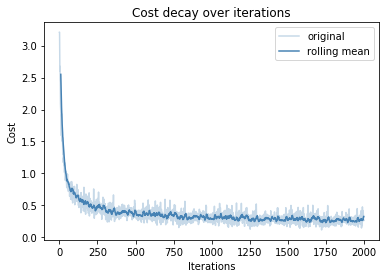

In [270]:

class CNN():
    
    def __init__(self, 
                 max_iter = 1000, 
                 batch_size = 128, 
                 alpha = 0.01, 
                 n_h = 100, 
                 learning_rate = 0.02):
        self.max_iter = max_iter
        self.batch_size = 128
        self.alpha = alpha
        self.n_h = n_h
        self.learning_rate = learning_rate
    
    def __enter__(self):
        return self
    
    def conv_layer(self, X, shape):
        W = tf.Variable(tf.truncated_normal(shape, stddev=0.1))
        b = bias_variable([shape[3]])
        Z = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
        return tf.nn.relu(Z + b)
        
    def fit(self, X_data, y_data):
        tf.reset_default_graph()
        sess = tf.Session()
        n_x, n_y = X_data.shape[1], len(np.unique(y_data))

        X = tf.placeholder(dtype=tf.float32, shape=[None, n_x], name = "X")
        y = tf.placeholder(dtype=tf.int32, shape=[None], name = "y")

        y_oh = tf.one_hot(y, name = "y_oh", depth = n_y)

        print("X:", X)
        print("y:", y)
        
        X_image = tf.reshape(X, [-1, 28, 28, 1])
        
        conv1 = conv_layer(X_image, [5, 5, 1, 32])

        W1 = tf.Variable(tf.truncated_normal([n_x, n_h], stddev=0.1, seed = 1, dtype=tf.float32), name = "W1")
        b1 = tf.Variable(tf.zeros(shape=[n_h]), dtype=tf.float32, name="b1")

        Z1 = tf.matmul(X, W1) + b1
        print("Z: ", Z1)

        A1 = tf.nn.tanh(Z1)
        print("A1:", A1)

        W2 = tf.Variable(tf.truncated_normal([n_h, n_y], stddev=0.1, seed = 1, dtype=tf.float32), name = "W2")
        b2 = tf.Variable(tf.zeros(shape=[n_y]), dtype=tf.float32, name="b2")

        Z2 = tf.matmul(A1, W2) + b2
        print("Z: ", Z1)


        y_pred = tf.cast(tf.argmax(Z2, axis=1), tf.int32)
        print("y_pred: ", y_pred)

        matched = tf.equal(y_pred, y)
        print("matched:", matched)

        accuracy = tf.reduce_mean(tf.cast(matched, tf.float32))
        print("accuracy: ", accuracy)

        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W1)
        tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, W2)

        regularizer = tf.contrib.layers.l2_regularizer(scale=self.alpha)
        reg_penalty = tf.contrib.layers.apply_regularization(regularizer, 
                                tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_oh, logits = Z2))
        cost_reg = cost + reg_penalty
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate).minimize(cost_reg)
        
        sess.run(tf.global_variables_initializer())
        scores = {}
        batchable = Batchable(X_data, y_data, batch_size=self.batch_size, seed=1)

        for i in range(max_iter):
            X_batch, y_batch = batchable.next()
            cost_,_ = sess.run([cost, optimizer], feed_dict={X: X_batch, y: y_batch})
            scores[i] = cost_
            if i % (max_iter // 10) == 0:
                print(i, cost_)
        plot_scores(scores)
                
        self.X = X
        self.y = y
        self.y_pred = y_pred
        self.accuracy = accuracy
        self.sess = sess
        return
    
    def predict(self, X_data):
        sess = self.sess
        X = self.X
        y = self.y
        y_pred_ = sess.run([self.y_pred], feed_dict={X: X_data})
        return y_pred_
    
    def score(self, X_data, y_data):
        sess = self.sess
        X = self.X
        y = self.y
        accuracy_ = sess.run(self.accuracy, feed_dict={X: X_data, y: y_data})
        return accuracy_
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.sess.close()

    
with CNN() as cnn:
    cnn.fit(X_train_std, y_train)
    print("Test accuracy: ", cnn.score(X_test_std, y_test))